In [1]:
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

## Данные

собираю примеры из нескольких отдельных файлов

In [2]:
contrast_df = pd.read_csv('Data\contrast_clean_extended.tsv', sep='\t')
cause_df = pd.read_csv('Data\cause_clean_extended.tsv', sep='\t')

In [3]:
df1 = contrast_df
df1['relation'] = 'contrast'
df1.head()

,id,текст,relation
0,407,"В солнечный день, наверное, и вода играет друг...",contrast
1,921,там никто не в курсе никаких автобусов_говорят...,contrast
2,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast
3,1067,"Что ни говори, общий относительно приличный ур...",contrast
4,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast


In [4]:
df2 = cause_df
df2['relation'] = 'cause'
df2.head()

,id,текст,relation
0,24,"Помада довольно стойкая,_отлично переживет пер...",cause
1,101,Выпадает небольшой осадок._Всегда встряхиваю п...,cause
2,136,"зато есть ощущение, что присутствует муцин ули...",cause
3,206,"Не самый послушный,_может осыпаться под глаза.",cause
4,392,После октябрьской революции_монастырь официаль...,cause


склеиваю два датафрейма и проверяю, что нигде ничего не потерялось (нет пустых значений)

In [5]:
all_data = pd.concat([df1, df2], ignore_index=True)
all_data.isna().any()

id          False
текст       False
relation    False
dtype: bool

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
id          200 non-null int64
текст       200 non-null object
relation    200 non-null object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


Разделяю пример на две ЭДЕ по `_`

In [7]:
new_df = all_data['текст'].str.split('_',expand=True)
new_df = new_df.rename(columns={0:'эде1', 1:'эде2'})
all_data = pd.concat([ all_data, new_df[['эде1', 'эде2']] ], axis=1)
all_data.head()

,id,текст,relation,эде1,эде2
0,407,"В солнечный день, наверное, и вода играет друг...",contrast,"В солнечный день, наверное, и вода играет друг...","Главное, что это не повод сидеть дома,"
1,921,там никто не в курсе никаких автобусов_говорят...,contrast,там никто не в курсе никаких автобусов,говорят; что всё на автостанцию приходит.
2,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast,В каком-то проёме за щёлкой эти монетки и оста...,И даже никаких чеков автомат не выдаёт.
3,1067,"Что ни говори, общий относительно приличный ур...",contrast,"Что ни говори, общий относительно приличный ур...",Автобусный транспорт реально много где на уров...
4,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast,"Коробка красивая,","прибор явно туфтовый, даже по внешнему виду."


# Признаки

считаю все признаки, которые можно получить автоматически

## Длины

Токенизирую тексты и считаю следующие параметры (учитывая только слова, без пунктуации):

`n_words` - кол-во слов в каждой ЭДЕ

`av_words_length` - средняя длина слова в каждой ЭДЕ

`n_words_diff` - разница в кол-вах между словами (знак показывает, какая из ЭДЕ длинее)

In [8]:
import re
from razdel import tokenize

In [9]:
def tokenizer(text_data):
    tokens = [_.text for _ in list(tokenize(str(text_data).lower()))] #if not re.search('[^а-яА-ЯёЁa-zA-z]', _.text)]
    return " ".join(tokens)

def get_words(tokens):
    words = [token for token in tokens.split() if not re.search('[^а-яА-ЯёЁa-zA-z]', token)]
    return " ".join(words)

def count_words(words):
    return len(words.split())

def av_word_length(words):
    l = [len(word) for word in words.split()]
    return sum(l)/len(l)

In [10]:
for i in ['1', '2']:
    all_data['tokens'+i] = all_data['эде'+i].progress_apply(tokenizer)
    all_data['words'+i] = all_data['tokens'+i].progress_apply(get_words)
    all_data['n_words'+i] = all_data['words'+i].progress_apply(count_words)
    all_data['av_words_length'+i] = all_data['words'+i].progress_apply(av_word_length)

In [11]:
all_data['n_words_diff'] = all_data['n_words1'] - all_data['n_words2']

Распределение длин

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
all_data.groupby(by='relation').mean()

,id,n_words1,av_words_length1,n_words2,av_words_length2,n_words_diff
relation,,,,,,
cause,7962.52,6.83,5.867120,6.50,5.849493,0.33
contrast,10371.23,8.38,5.774431,6.68,5.980861,1.70


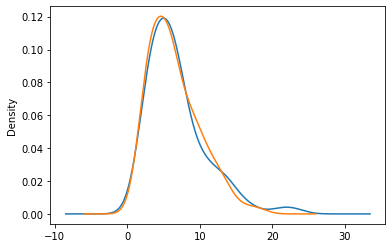

In [14]:
all_data[all_data['relation'] == 'cause']['n_words1'].plot.kde()
all_data[all_data['relation'] == 'cause']['n_words2'].plot.kde()

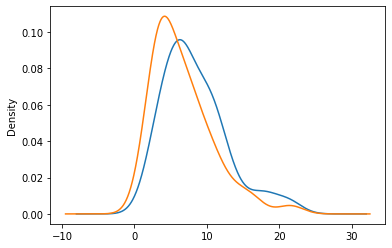

In [15]:
all_data[all_data['relation'] == 'contrast']['n_words1'].plot.kde()
all_data[all_data['relation'] == 'contrast']['n_words2'].plot.kde()

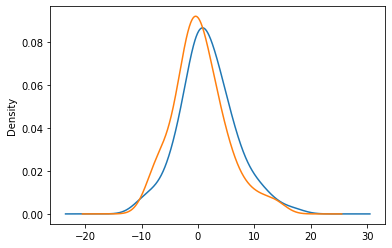

In [16]:
all_data[all_data['relation'] == 'contrast']['n_words_diff'].plot.kde()
all_data[all_data['relation'] == 'cause']['n_words_diff'].plot.kde()

## Пунктуация между ЭДЕ

`punct` - знак препинания между двумя ЭДЕ (беру последний токен первой ЭДЕ). _None_ если знаков там нет. Данные заранее нормализованы вручную так, чтобы знак оставался в первом элементе. 

In [17]:
def find_punct(tokens):
    last = tokens[-1]
    if last not in ['.', ',', ':', '-', '?', ')', '…']:
        last = 'none'
        
    return last

all_data['punct'] = all_data['tokens1'].apply(find_punct)
all_data['if punct'] = (all_data['punct'] != 'none')

## POS анализ

Считаю вектор со значениями всех частей речи и разбиваю его на отдельные признаки

In [18]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [19]:
tag_list = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN',
            'NPRO', 'NUMR', 'None', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']

In [20]:
def count_POS(words):
    POS_dict = {'ADJF': 0,
                'ADJS': 0,
                'ADVB': 0,
                'COMP': 0,
                'CONJ': 0,
                'GRND': 0,
                'INFN': 0,
                'INTJ': 0,
                'NOUN': 0,
                'NPRO': 0,
                'NUMR': 0,
                'None': 0,
                'PRCL': 0,
                'PRED': 0,
                'PREP': 0,
                'PRTF': 0,
                'PRTS': 0,
                'VERB': 0}
    
    for word in words.split():
        p = morph.parse(word)[0]
        tag = p.tag.POS
        if tag is None:
            tag = 'None'
        POS_dict[tag] += 1
    return list(POS_dict.values())

In [21]:
for i in ['1', '2']:
    all_data['pos_vector'+i] = all_data['words'+i].progress_apply(count_POS)
    
    all_data[ [tag+i for tag in tag_list] ] = pd.DataFrame(all_data['pos_vector'+i].tolist())

## Повторяющиеся слова

Лемматизирую тексты и считаю сколько слов встречаются в обеих ЭДЕ

In [22]:
def lemmatizer(words):
    lem_text = []
    for word in words.split():
        lem = morph.parse(word)[0].normal_form
#         if lem not in stops:
        lem_text.append(lem)
    return ' '.join(lem_text)

def similar_words(lemm_a, lemm_b):
    return list(set(lemm_a.split()) & set(lemm_b.split()))

In [23]:
for i in ['1', '2']:
    all_data['lemm'+i] = all_data['words'+i].progress_apply(lemmatizer)

In [24]:
all_data['similar_words'] = all_data.apply(lambda x: similar_words(x['lemm1'], x['lemm2']), axis=1)
all_data['n_similar_words'] = all_data['similar_words'].apply(len)

In [25]:
all_data[all_data['n_similar_words'] != 0]['similar_words']

2                                          [и]
3                         [уровень, транспорт]
9                                          [с]
11                                    [бывать]
15                                       [кот]
18                                    [писать]
20                                       [для]
21                                  [хотеться]
22          [быстрый, результат, это, к, путь]
23                         [пищеварение, быть]
25                           [платить, тестер]
26                                  [работать]
27                         [ресурс, требовать]
28                                    [способ]
30                                       [что]
32                                [технология]
34                                        [не]
35                                 [хотеть, я]
37                     [что, я, мочь, сказать]
39                                  [удобство]
41                   [нужно, что, это, значит]
42           

## Эмбединги

Обучаю модель, получаю вектора размерности 10 для каждой пары ЭДЕ и считаю их косинусную близовть. Вектора разбиваю на 10 отдельных признаков. Как дальше покажут эксперименты, если использовать эти 10 отдельных признаков, то почти все модели получаются сильно завязаны на каку-то их часть, при этом если их не использовать - качество не особо и меняется. Так что в итоге при обучении я буду использовать только значение близости между векторами двух ЭДЕ `cosine_d2v`.

### doc2vec

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [27]:
corpora = all_data['lemm1'].values.tolist() + all_data['lemm2'].values.tolist()
len(corpora)

400

In [28]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(corpora)]
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1)

In [29]:
def get_d2v_vector(lemm):
    return model.infer_vector(lemm.split())

def cosine_d2v(lemm1, lemm2):
    return model.wv.n_similarity(lemm1.split(),lemm2.split())

In [30]:
for i in ['1', '2']:
    all_data['d2v_vector'+i] = all_data['lemm'+i].progress_apply(get_d2v_vector)
    all_data[ ['v'+str(n)+'_'+i for n in range(10)] ] = pd.DataFrame(all_data['d2v_vector'+i].tolist())

In [31]:
all_data['cosine_d2v'] = all_data.apply(lambda x: cosine_d2v(x['lemm1'], x['lemm2']), axis=1)

### Сохранение всех результатов в экселе

In [32]:
all_data.to_excel('Data\data_full_markup.xlsx')

# Модели

In [33]:
import numpy as np
from sklearn.metrics import classification_report

## Обчающая и тестовая выборки

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [35]:
not_features = ['id', 'текст',
                'эде1', 'эде2',
                'tokens1', 'tokens2',
                'words1', 'words2',
                'pos_vector1', 'pos_vector2',
                'lemm1', 'lemm2',
                'similar_words', 'if punct', 
                'd2v_vector1', 'd2v_vector2']

not_features.extend(['v'+str(n)+'_'+'1' for n in range(10)])
not_features.extend(['v'+str(n)+'_'+'2' for n in range(10)])

features_list = list(set(all_data.columns.values.tolist()) - set(not_features))
features_list.remove('relation')

data = all_data.drop(columns=not_features)
data = data.apply(LabelEncoder().fit_transform) # 1 = contrast, 0 = cause

X = data.drop(columns=['relation'])
y = data['relation']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [36]:
len(features_list)

44

In [65]:
X_test

,n_words1,av_words_length1,n_words2,av_words_length2,n_words_diff,punct,ADJF1,ADJS1,ADVB1,COMP1,...,NUMR2,None2,PRCL2,PRED2,PREP2,PRTF2,PRTS2,VERB2,n_similar_words,cosine_d2v
137,8,75,4,86,15,1,1,0,1,1,...,0,0,0,0,0,0,0,1,0,174
40,4,15,4,58,11,2,1,0,0,1,...,0,0,3,0,0,0,0,1,0,111
95,4,72,3,32,12,2,0,0,0,0,...,0,0,0,0,0,0,0,1,1,154
96,3,78,7,35,7,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,35
123,0,56,9,36,2,0,0,0,0,0,...,0,0,0,1,2,0,0,0,0,165
4,0,86,6,29,5,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,92
129,1,9,11,17,1,0,0,0,0,0,...,0,0,0,0,3,1,0,1,0,96
80,0,40,6,52,5,5,0,0,0,0,...,0,0,0,0,0,0,0,1,1,186
61,19,57,4,70,25,2,6,0,0,0,...,0,0,0,0,1,0,0,0,1,99
186,4,40,10,76,5,0,1,0,0,0,...,1,0,0,0,2,0,0,1,0,3


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 154 to 5
Data columns (total 44 columns):
n_words1            160 non-null int64
av_words_length1    160 non-null int64
n_words2            160 non-null int64
av_words_length2    160 non-null int64
n_words_diff        160 non-null int64
punct               160 non-null int32
ADJF1               160 non-null int64
ADJS1               160 non-null int64
ADVB1               160 non-null int64
COMP1               160 non-null int64
CONJ1               160 non-null int64
GRND1               160 non-null int64
INFN1               160 non-null int64
INTJ1               160 non-null int64
NOUN1               160 non-null int64
NPRO1               160 non-null int64
NUMR1               160 non-null int64
None1               160 non-null int64
PRCL1               160 non-null int64
PRED1               160 non-null int64
PREP1               160 non-null int64
PRTF1               160 non-null int64
PRTS1               160 non-null int6

## Корреляция признаков

вроде сильно коррелирующих нет

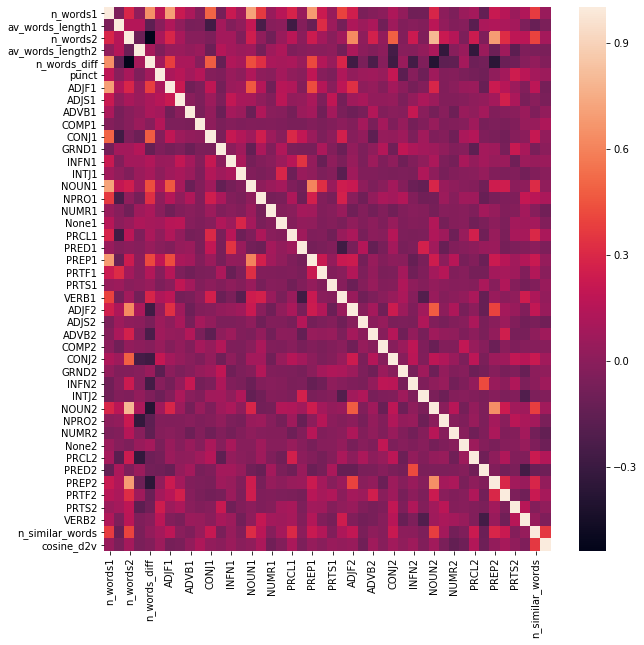

In [38]:
corr_matrix = data.drop(columns=['relation']).corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix)

### Корреляция между признаками и классом

In [39]:
feature_corr = np.empty(0)

for f in features_list:
    feature_corr = np.append(feature_corr, data[['relation', f]].corr()['relation'][f])
    
for ind in np.argsort(-feature_corr):
    print(features_list[ind], '-', feature_corr[ind])

n_similar_words - 0.24938907724170786
PRCL2 - 0.22423052782558048
n_words1 - 0.18248905029295673
PRCL1 - 0.16947553762062917
ADJF1 - 0.16485989852481342
ADJS1 - 0.15309310892394895
NOUN1 - 0.14864888347169689
n_words_diff - 0.1396137509584346
cosine_d2v - 0.1280001546912738
ADJF2 - 0.12121830534626488
VERB1 - 0.12027695586485297
INTJ2 - 0.11724207635210979
punct - 0.09976037959994381
CONJ1 - 0.0970494958830943
INFN1 - 0.08835852486128691
INTJ1 - 0.08161943426864189
NUMR1 - 0.07142857142857151
None2 - 0.07088812050083323
PRTF2 - 0.060845543573612736
PREP2 - 0.05463583647081531
PRED1 - 0.05324139056496659
PREP1 - 0.05200401152588276
av_words_length2 - 0.02976722807720608
ADJS2 - 0.02720647808954716
NOUN2 - 0.025854491181538285
CONJ2 - 0.025822040901125175
n_words2 - 0.01857273628971618
av_words_length1 - -0.012286604849893192
NPRO2 - -0.018979740450028024
None1 - -0.019924430474521027
COMP1 - -0.02411915350974739
NPRO1 - -0.03907323325822833
PRTS1 - -0.041134503489486336
ADVB1 - -0.05001

## Статистическая значимость признаков

без комментариев

In [40]:
from sklearn.feature_selection import chi2

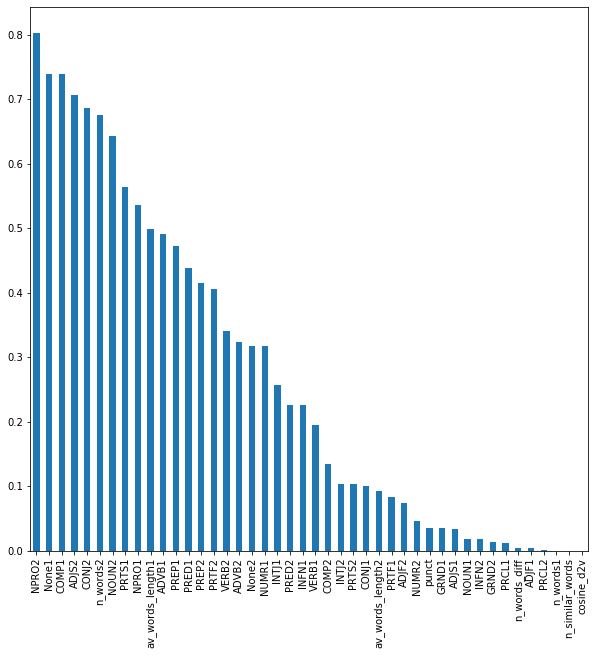

In [41]:
chi_scores = chi2(X, y)
p_values = pd.Series(chi_scores[1], index = X.columns)
p_values.sort_values(ascending = False, inplace = True)
plt.subplots(figsize=(10,10))
p_values.plot.bar()

## Логистическая регрессия

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lreg = LogisticRegression(random_state=42)
lreg.fit(X_train, y_train)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred_lreg = lreg.predict(X_test)
print(classification_report(y_test, y_pred_lreg))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       0.85      0.55      0.67        20

    accuracy                           0.73        40
   macro avg       0.76      0.73      0.72        40
weighted avg       0.76      0.72      0.72        40



In [45]:
feature_importances_lreg = lreg.coef_
for ind in np.argsort(-feature_importances_lreg[0]):
    print(X_train.columns[ind], '-', feature_importances_lreg[0][ind])

ADJS1 - 1.0989811636527205
INTJ1 - 0.9259558187954454
n_similar_words - 0.7047507669396752
PRCL2 - 0.597582107815822
INTJ2 - 0.5735262672469239
ADJF2 - 0.5375832396762608
VERB1 - 0.5340403127685922
NPRO2 - 0.5222443517756898
None2 - 0.4567790061503608
PREP2 - 0.42509840200851273
NUMR1 - 0.4122408327838444
PRED1 - 0.3885899160164885
ADJF1 - 0.2691651368653796
CONJ2 - 0.24385060792503233
PRCL1 - 0.23160371196490565
n_words1 - 0.16111078803335982
punct - 0.1319334398337
ADJS2 - 0.13041013338292487
INFN1 - 0.1233860630044201
ADVB1 - 0.12154801012428995
NOUN1 - 0.10948427101687337
COMP2 - 0.05365846683113117
PRED2 - 0.03166794495697791
av_words_length2 - 0.009433588887810722
cosine_d2v - 0.0035632048202110774
av_words_length1 - 0.0023015728929119774
NOUN2 - -0.00734492171837695
PRTS1 - -0.0190842406050088
CONJ1 - -0.09887737528008168
PREP1 - -0.10564370498906597
n_words_diff - -0.1597731627027079
PRTF2 - -0.22085738776319733
ADVB2 - -0.23138659321727673
VERB2 - -0.24629588114214748
NUMR2 - 

## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [48]:
y_pred_tree = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.52      0.70      0.60        20
           1       0.54      0.35      0.42        20

    accuracy                           0.53        40
   macro avg       0.53      0.52      0.51        40
weighted avg       0.53      0.53      0.51        40



In [49]:
feature_importances_tree = tree_clf.feature_importances_
for ind in np.argsort(-feature_importances_tree):
    print(X_train.columns[ind], '-', feature_importances_tree[ind])

n_words2 - 0.11197115975742289
n_words_diff - 0.10464758594599707
n_similar_words - 0.10121457489878546
NPRO1 - 0.09511835329970575
INFN1 - 0.05958333333333332
av_words_length2 - 0.05333333333333333
av_words_length1 - 0.052826510721247597
ADJF2 - 0.0446716147273956
GRND1 - 0.04292679479932162
GRND2 - 0.033939393939393915
NOUN1 - 0.03323863636363637
cosine_d2v - 0.03321428571428573
n_words1 - 0.032608695652173905
ADJS1 - 0.03109507954125048
PRTF1 - 0.029701468710089385
PRCL2 - 0.02554278416347382
VERB1 - 0.023116395099153707
COMP2 - 0.022500000000000006
PREP2 - 0.01875
PREP1 - 0.01666666666666667
NPRO2 - 0.016666666666666666
NOUN2 - 0.016666666666666666
PRTS2 - 0.0
PRTF2 - 0.0
PRED2 - 0.0
INTJ2 - 0.0
None2 - 0.0
NUMR2 - 0.0
VERB2 - 0.0
INFN2 - 0.0
INTJ1 - 0.0
CONJ1 - 0.0
ADVB2 - 0.0
ADJS2 - 0.0
ADJF1 - 0.0
PRTS1 - 0.0
PRED1 - 0.0
PRCL1 - 0.0
None1 - 0.0
NUMR1 - 0.0
ADVB1 - 0.0
COMP1 - 0.0
punct - 0.0
CONJ2 - 0.0


## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [52]:
y_pred_forest = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64        20
           1       0.62      0.50      0.56        20

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



In [53]:
feature_importances_forest = rf_clf.feature_importances_
for ind in np.argsort(-feature_importances_forest):
    print(X_train.columns[ind], '-', feature_importances_forest[ind])

cosine_d2v - 0.07567768055506847
av_words_length2 - 0.06498063573428901
av_words_length1 - 0.06397024493817423
n_similar_words - 0.06020444848369864
n_words_diff - 0.05813854188542212
n_words1 - 0.05805561726278077
NOUN1 - 0.04773219103862678
n_words2 - 0.04484501677338018
NOUN2 - 0.03821815983540855
ADJF1 - 0.03565053516574672
punct - 0.034594159999035395
ADJF2 - 0.028185234165166707
PRCL1 - 0.02541571046868854
CONJ1 - 0.02445682419953397
VERB1 - 0.02300471538992793
PREP2 - 0.022290748257444763
PRCL2 - 0.022061871152403278
VERB2 - 0.021406788483628744
NPRO1 - 0.020024049119811312
ADVB1 - 0.019988579601373
PREP1 - 0.01879344487581272
ADVB2 - 0.018043411515492887
INFN2 - 0.01724275489683374
GRND2 - 0.017157314777954756
PRTF1 - 0.014438466596134743
CONJ2 - 0.014293123731311648
INFN1 - 0.014121383781719348
NPRO2 - 0.013269447742158809
GRND1 - 0.01289385920489358
ADJS1 - 0.01107592237725287
INTJ1 - 0.008517205784771047
COMP2 - 0.008483171593362659
COMP1 - 0.005490159096901803
PRED1 - 0.005

## SVM

In [54]:
from sklearn.svm import SVC

In [55]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [56]:
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        20
           1       0.75      0.60      0.67        20

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



In [57]:
feature_importances_svc = svc.coef_
for ind in np.argsort(-feature_importances_svc[0]):
    print(X_train.columns[ind], '-', feature_importances_svc[0][ind])

INTJ1 - 1.0968109680505418
ADJS1 - 1.0682571426069154
None2 - 0.7117499686699064
PRCL2 - 0.6455992035018312
n_similar_words - 0.6306846723706426
n_words1 - 0.6073957112629316
VERB1 - 0.5286519333174455
NPRO2 - 0.45723827396412675
PREP2 - 0.3888912925311774
PRED1 - 0.38681854790401576
CONJ2 - 0.34430816424710153
ADJF2 - 0.33340315098044826
COMP2 - 0.302621965970953
ADJF1 - 0.2543402361971072
ADJS2 - 0.21207930691505192
NUMR1 - 0.17537227392355925
PRCL1 - 0.16134142990523292
PREP1 - 0.10851466327660653
INTJ2 - 0.09681096805054182
PRTS1 - 0.09248039059433666
INFN1 - 0.09083609995569297
punct - 0.06279635776936043
NOUN1 - 0.04716419491652246
av_words_length2 - 0.013580182589862488
cosine_d2v - 0.004000272596954346
av_words_length1 - 0.0016929829472474012
ADVB1 - -0.034216656387572986
GRND1 - -0.07280986883423113
PRTS2 - -0.07280986883423113
PRED2 - -0.08596603923555923
NOUN2 - -0.10616641429474427
VERB2 - -0.17204075773787686
NUMR2 - -0.20014683351139034
CONJ1 - -0.20586656116487623
None1 

## Сравнение качества моделей

### F1-score

In [58]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['f1-score']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['f1-score']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['f1-score']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['f1-score']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.765957,0.595745,0.636364,0.727273
contrast,0.666667,0.424242,0.555556,0.666667


### Precision

In [59]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['precision']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['precision']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['precision']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['precision']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.666667,0.518519,0.583333,0.666667
contrast,0.846154,0.538462,0.625000,0.750000


### Recall

In [60]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['recall']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['recall']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['recall']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['recall']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.90,0.70,0.7,0.8
contrast,0.55,0.35,0.5,0.6


## Сравнение важности признаков

Сравниваю абсолютные значения всех признаков

In [61]:
features = pd.DataFrame({'LReg': abs(feature_importances_lreg[0]), 
              'DTree': feature_importances_tree, 
              'RForest': feature_importances_forest,
              'SVM': abs(feature_importances_svc[0]),}, index=X_train.columns)

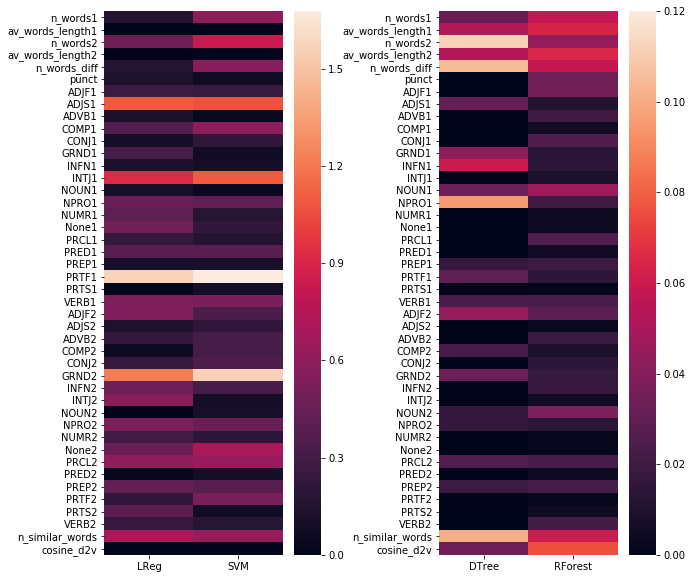

In [62]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(10,10))
fig.subplots_adjust(wspace=0.5)
sns.heatmap(features[['LReg', 'SVM']], cmap="rocket", ax=ax, cbar=True, vmin=0)
sns.heatmap(features[['DTree', 'RForest']], cmap="rocket", ax=ax2, cbar=True, vmax=0.12)
plt.show()

In [63]:
features

,LReg,DTree,RForest,SVM
n_words1,0.161111,0.032609,0.058056,0.607396
av_words_length1,0.002302,0.052827,0.063970,0.001693
n_words2,0.466779,0.111971,0.044845,0.835944
av_words_length2,0.009434,0.053333,0.064981,0.013580
n_words_diff,0.159773,0.104648,0.058139,0.574636
punct,0.131933,0.000000,0.034594,0.062796
ADJF1,0.269165,0.000000,0.035651,0.254340
ADJS1,1.098981,0.031095,0.011076,1.068257
ADVB1,0.121548,0.000000,0.019989,0.034217
COMP1,0.354711,0.000000,0.005490,0.585038


## Ошибки

In [68]:
X_test['y_pred_lreg'] = y_pred_lreg
X_test['y_pred_tree'] = y_pred_tree
X_test['y_pred_forest'] = y_pred_forest
X_test['y_pred_svc'] = y_pred_svc
X_test['class'] = y_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [81]:
res_df = pd.concat([all_data, X_test], axis=1, join='inner')
mistakes = res_df[['эде1', 'эде2', 'class', 'y_pred_lreg', 'y_pred_forest', 'y_pred_svc']]
mistakes['comb'] = mistakes[['class', 'y_pred_lreg', 'y_pred_forest', 'y_pred_svc']].sum(axis=1)
out = mistakes[(mistakes['comb'] != 0)&(mistakes['comb'] != 4)]
out

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,эде1,эде2,class,y_pred_lreg,y_pred_forest,y_pred_svc,comb
4,"Коробка красивая,","прибор явно туфтовый, даже по внешнему виду.",1,0,0,0,1
6,"Он потом рассказывал, что я смотрела на него в...",- и не видела!,1,0,0,0,1
7,"На лице официанта явно читается «мадам, вы не ...",у нас едят долго и вдумчиво».,1,0,0,0,1
32,Технология редко оказывается настоящим источни...,"Почти всегда дело в людях, не разобравшихся, к...",1,0,1,0,2
33,"Зоопарк технологий создает проблемы,",как бы вам не хотелось верить в обратное.,1,0,0,1,2
36,"Это давно пора зафиксировать,","я просто немножко тормоз, конечно",1,0,0,0,1
40,"Все выглядит так, как было раньше.",Вот только самолеты не приземляются.,1,1,0,1,3
43,Если создание цифровой экономики даёт России х...,все остальные сценарии ведут к неизбежному про...,1,1,0,1,3
47,стоит миру как-то пошатнуться.,"Я - совсем не спортсменка,",1,1,0,1,3
72,"начиная от дорожных знаков,","заканчивая надписью ""Спасибо"" на товарных чеках.",1,0,0,0,1


In [82]:
out.to_excel('mistakes.xlsx')

_Анна Полянская, НИУ ВШЭ, 2020_